## **Class Activation Maps (CAM) and Saliency Maps are techniques used to visualize and understand the important regions of an input image that contribute to the prediction of a neural network, especially Convolutional Neural Networks (CNNs).**


* ### CAM produces a heatmap that highlights discriminative regions of an image related to a specific class by associating importance weights with different spatial locations in the image. It weights the feature maps based on the importance values and produces a weighted combination.


* ### Saliency Maps highlight high-gradient areas that significantly impact the model's output. Saliency Maps are based on gradient calculations between the input image and the predicted class, focusing on pixel-wise sensitivity.

In [71]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
import numpy as np
import os
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Dataset Describtion**
* train - 70%
* test - 20%
* validation - 10%

In [72]:
# Define the paths to our train, validation, and test datasets
train_data_dir = '/kaggle/input/fracture-classification/Fracture/train'
test_data_dir = '/kaggle/input/fracture-classification/Fracture/test'
validation_data_dir = '/kaggle/input/fracture-classification/Fracture/validation'

# **Image dimensions**

In [73]:
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)  # RGB images
batch_size = 16

# **Data generators**

In [74]:
# Data generators for RGB images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)



# Define data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

# Generate augmented data for training
train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary',
  
)


# Define data generators for RGB images with augmentation
test_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='binary',
    shuffle=False,
   
)

# Define data generators for RGB images with augmentation
validation_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    class_mode='binary',
    shuffle=False,
   
)




Found 2858 images belonging to 2 classes.
Found 816 images belonging to 2 classes.
Found 409 images belonging to 2 classes.


# **{'Fractured': 0, 'Non_fractured': 1}**

In [75]:
class_indices = train_generator.class_indices
print(class_indices)

{'Fractured': 0, 'Non_fractured': 1}


# **Number of images for each class in the training dataset**

In [76]:
# Count the number of images for each class in the training dataset
classes = os.listdir(train_data_dir)
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Non_fractured, Number of images: 2356
Class: Fractured, Number of images: 502


# **Check the shape of the images in Train Generator**

In [77]:
# Get a batch of images and labels from the train_generator
batch = train_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 224x224x3, Label: 1.0
Image 2 - Shape: 224x224x3, Label: 1.0
Image 3 - Shape: 224x224x3, Label: 0.0
Image 4 - Shape: 224x224x3, Label: 1.0
Image 5 - Shape: 224x224x3, Label: 1.0
Image 6 - Shape: 224x224x3, Label: 1.0
Image 7 - Shape: 224x224x3, Label: 1.0
Image 8 - Shape: 224x224x3, Label: 1.0
Image 9 - Shape: 224x224x3, Label: 0.0
Image 10 - Shape: 224x224x3, Label: 1.0
Image 11 - Shape: 224x224x3, Label: 1.0
Image 12 - Shape: 224x224x3, Label: 1.0
Image 13 - Shape: 224x224x3, Label: 1.0
Image 14 - Shape: 224x224x3, Label: 1.0
Image 15 - Shape: 224x224x3, Label: 1.0
Image 16 - Shape: 224x224x3, Label: 1.0


# **Number of images for each class in the testing dataset**

In [78]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(test_data_dir)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Non_fractured, Number of images: 673
Class: Fractured, Number of images: 143


# **Check the shape of the images in Test Generator**

In [79]:
# Get a batch of images and labels from the test_generator
batch = test_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 224x224x3, Label: 0.0
Image 2 - Shape: 224x224x3, Label: 0.0
Image 3 - Shape: 224x224x3, Label: 0.0
Image 4 - Shape: 224x224x3, Label: 0.0
Image 5 - Shape: 224x224x3, Label: 0.0
Image 6 - Shape: 224x224x3, Label: 0.0
Image 7 - Shape: 224x224x3, Label: 0.0
Image 8 - Shape: 224x224x3, Label: 0.0


# **Number of images for each class in the validation dataset**

In [80]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(test_data_dir)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Non_fractured, Number of images: 673
Class: Fractured, Number of images: 143


# **Check the shape of the images in Validation Generator**

In [81]:
# Get a batch of images and labels from the validation_generator
batch = validation_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 224x224x3, Label: 0.0
Image 2 - Shape: 224x224x3, Label: 0.0
Image 3 - Shape: 224x224x3, Label: 0.0
Image 4 - Shape: 224x224x3, Label: 0.0
Image 5 - Shape: 224x224x3, Label: 0.0
Image 6 - Shape: 224x224x3, Label: 0.0
Image 7 - Shape: 224x224x3, Label: 0.0
Image 8 - Shape: 224x224x3, Label: 0.0


# **Check for GPU availability**

In [82]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


# **Cost-Sensitive Learning involves adjusting the loss function or misclassification costs to account for the imbalanced distribution of classes.**

## **Weighted Loss Function:**
### Modify the loss function to give more weight to the minority class (Fracture) during training. This adjustment helps the model to focus more on correctly classifying the minority class instances.

## **Class Weights:**
### Assign different weights to each class in the loss calculation. Weight the loss associated with the Fracture class higher than the Non-Fracture class to reflect the class imbalance.

In [83]:
# Calculate class weights
# We can assign higher weight to the Fractured class (class 0)
# We can assign lower weight to the Fractured class (class 0)
weight_0 = 1.5897
weight_1 = 1

# Create class weights dictionary
class_weights = {0: weight_0, 1: weight_1}

# **Model checkpoint**

In [84]:
model_dir = '/kaggle/working/fracture vs non-fracture/model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

> # **DenseNet for Feature Extractor** 
## **1.** DenseNet121
## **2.** DenseNet169
## **3.** DenseNet201
* # Change will be here

In [85]:
def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(base_model.layers[-1].output)
    output = Dense(1, activation='sigmoid')(flat1)  # Change to 1 for binary classification
    # define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    # Modify loss function to 'weighted_binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model


# **Model summary**

In [86]:
model = create_model()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

# **Training starts here**

In [87]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    class_weight=class_weights,  # Use class_weights dictionary here
    callbacks=[cp_callback]
    
)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 3.0511 - accuracy: 0.7063
Epoch 1: saving model to /kaggle/working/fracture vs non-fracture/model/cp.ckpt
10/10 [==============================] - 65s 564ms/step - loss: 3.0511 - accuracy: 0.7063 - val_loss: 18.8036 - val_accuracy: 0.1125
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.6119 - accuracy: 0.7063
Epoch 2: saving model to /kaggle/working/fracture vs non-fracture/model/cp.ckpt
10/10 [==============================] - 4s 429ms/step - loss: 1.6119 - accuracy: 0.7063 - val_loss: 2398.5525 - val_accuracy: 0.9000
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.9545 - accuracy: 0.7937
Epoch 3: saving model to /kaggle/working/fracture vs non-fracture/model/cp.ckpt
10/10 [==============================] - 4s 435ms/step - loss: 1.9545 - accuracy: 0.7937 - val_loss: 261719.0000 - val_accuracy: 0.1000
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.5590 

# **Loading Saved Model**

In [88]:
# Load the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint is not None:
    # Create a new model instance
    loaded_model = create_model(summary=True)

    # Load the previously saved weights and silence the warnings
    status = loaded_model.load_weights(latest_checkpoint)
    status.expect_partial()  # Ignore unrestored variables
else:
    print("No checkpoint file found in the specified directory.")

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

# **Again Train the loaded model**

In [89]:
loaded_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
# Train the model
history = loaded_model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10,
    class_weight=class_weights,  # Use class_weights dictionary here
    callbacks=[cp_callback]
    
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 5.9781 - accuracy: 0.6687
Epoch 1: saving model to /kaggle/working/fracture vs non-fracture/model/cp.ckpt
10/10 [==============================] - 64s 543ms/step - loss: 5.9781 - accuracy: 0.6687 - val_loss: 15.2224 - val_accuracy: 0.1125
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 3.0152 - accuracy: 0.5125
Epoch 2: saving model to /kaggle/working/fracture vs non-fracture/model/cp.ckpt
10/10 [==============================] - 4s 427ms/step - loss: 3.0152 - accuracy: 0.5125 - val_loss: 42.1721 - val_accuracy: 0.1250
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 1.5921 - accuracy: 0.7437
Epoch 3: saving model to /kaggle/working/fracture vs non-fracture/model/cp.ckpt
10/10 [==============================] - 4s 461ms/step - loss: 1.5921 - accuracy: 0.7437 - val_loss: 258.4553 - val_accuracy: 0.1000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.7259 - acc

# **Save the history after using latest weights in a CSV file**

In [90]:
import pandas as pd 
pd.DataFrame(history.history).to_csv("/kaggle/working/Fracture_Epoch40.csv")

# **Accuracy and loss graph of training and validation**
## Here, No. of epochs and (xticks & yticks) will be changed

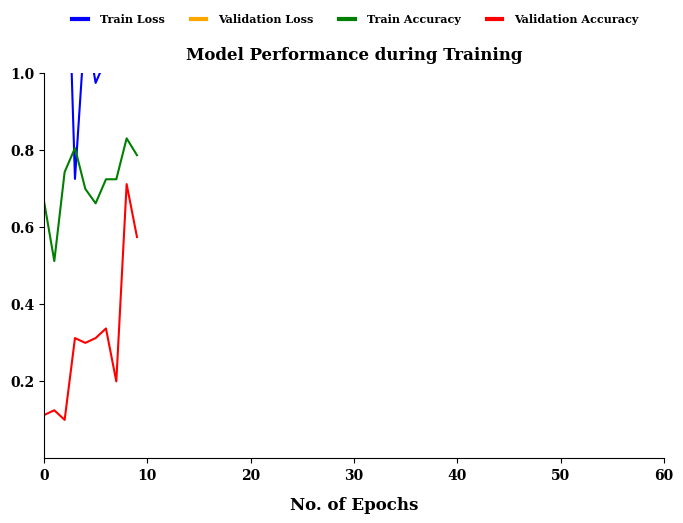

In [91]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(8, 5))

# Plot Loss
train_loss, = plt.plot(history.history['loss'], label='Train Loss', color='blue')
val_loss, = plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
train_accuracy, = plt.plot(history.history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
# Add a title with specified font properties
plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})



plt.xticks(np.linspace(0, 60, num=7), fontname='Serif', weight='bold')


# Set y-axis ticks font properties
plt.yticks(np.linspace(0.2, 1, num=5), fontname='Serif', weight='bold')


plt.xlim(0, 60)
plt.ylim(0, 1)

# Define custom legend lines with desired line properties
legend_lines = [
    Line2D([0], [0], color='blue', lw=3),          # Train Loss
    Line2D([0], [0], color='orange', lw=3),       # Validation Loss
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
           loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('/kaggle/working/resnet50_accuracy_graph.pdf')  # Save as pdf format
plt.show()


# **Testing starts here**

In [92]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

102/102 [==============================] - 4s 34ms/step - loss: 8.1492 - accuracy: 0.6961
Test Accuracy: 0.6960784196853638


In [93]:
# Predict labels for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the highest probability class
true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[:10])  # Display first 10 predicted classes
print("True Classes:", true_classes[:10])  # Display first 10 true classes


102/102 [==============================] - 5s 27ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
True Classes: [0 0 0 0 0 0 0 0 0 0]


In [94]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [95]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# **Evaluation Metircs**

In [96]:
print(f"Accuracy: {accuracy_score(true_classes, predicted_classes)}")
print(f"Precision: {precision_score(true_classes, predicted_classes)}")
print(f"Recall: {recall_score(true_classes, predicted_classes)}")
print(f"F1 Score: {f1_score(true_classes, predicted_classes)}")
print(f"Log Loss: {log_loss(true_classes, predicted_classes)}")
print(f"Jaccard Score: {jaccard_score(true_classes, predicted_classes)}")

Accuracy: 0.17524509803921567
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Log Loss: 29.727179817249798
Jaccard Score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Classification Report**

In [97]:
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       143
           1       0.00      0.00      0.00       673

    accuracy                           0.18       816
   macro avg       0.09      0.50      0.15       816
weighted avg       0.03      0.18      0.05       816



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Confusion Matrix**

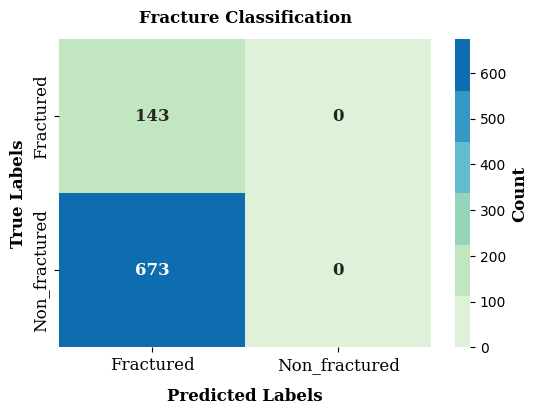

In [98]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette(palette='GnBu')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['Fractured', 'Non_fractured'], yticklabels=['Fractured', 'Non_fractured'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Fracture Classification', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.show()


# **ROC curve for ResNet50**

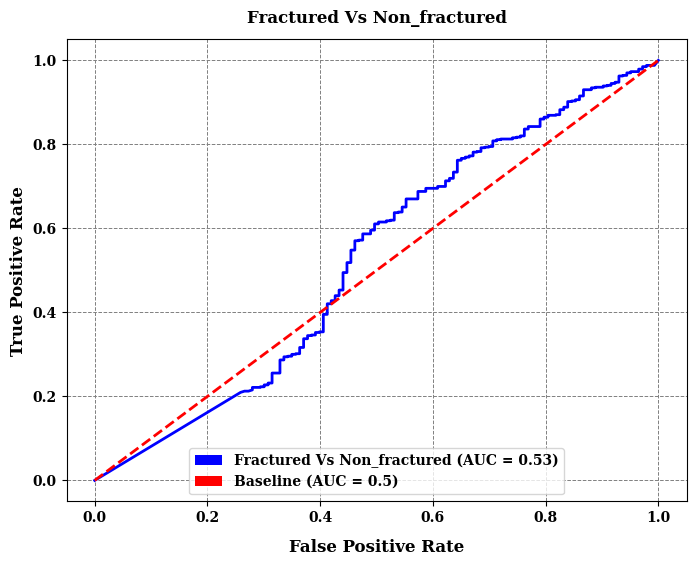

In [99]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# Assuming predicted probabilities for the "Fractured" class (class index 1)
positive_class_prob = predictions[:, 0]  # Adjust the index based on the column containing the probabilities
 # Replace 1 with the appropriate index for the "Fractured" class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_classes, positive_class_prob)
roc_auc = roc_auc_score(true_classes, positive_class_prob)


# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('Fractured Vs Non_fractured', fontdict=font, pad=12)

# Create legend entries with bbox
legend_handles = [
    Patch(facecolor='blue',  label='Fractured Vs Non_fractured (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

# Combine loss and accuracy labels with custom legend lines and bbox
plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})

# Enable grid with customized properties
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')

# Set x-axis ticks font properties
plt.xticks(fontname='Serif', weight='bold')

# Set y-axis ticks font properties
plt.yticks(fontname='Serif', weight='bold')

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

plt.show()


# **Checking model predictions for random images from test dataset**

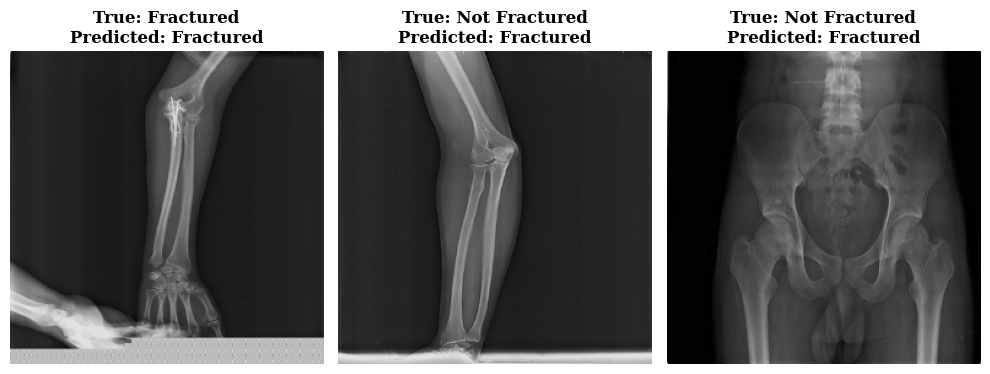

In [100]:
import random
import matplotlib.pyplot as plt
import cv2

# Get random indices for three images
random_indices = random.sample(range(len(true_classes)), 3)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices, 1):
    # Load the image
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    
    # Display the image
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis('off')
    
    # Display the true and predicted labels
    true_label = "Fractured" if true_classes[idx] == 0 else "Not Fractured"
    predicted_label = "Fractured" if predicted_classes[idx] == 0 else "Not Fractured"
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}",fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

plt.tight_layout()
plt.show()


# **No. 1 : Explainable AI (GradCAM)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Grad-CAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Grad-CAM heatmap using the model we've built)

# **Function for displaying GradCAM images**

In [101]:
# Function to save and display GradCAM
def save_and_display_gradcam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/DenseNet121_gradcam.pdf')  # Save as pdf format
    plt.show()



# **GradCAM function**
### **Gradient Calculation:** Using these activations, GradCAM computes the gradients of the predicted class's score with respect to the feature maps. These gradients indicate the importance of each feature map in determining the final class prediction.

### **Global Average Pooling (GAP):** GradCAM takes the gradients and performs Global Average Pooling (GAP) across the spatial dimensions of each feature map. This step generates a weight for each feature map, reflecting its relevance to the predicted class.

### **Weighted Combination:** GradCAM computes a weighted combination of the feature maps based on their importance weights obtained from GAP. This combination highlights the regions in the feature maps that strongly influence the predicted class.

### **Heatmap Generation:** The weighted combination produces a heatmap by overlaying these selected regions back onto the input image. The heatmap visually demonstrates which parts of the image are pivotal in the model's decision-making for the predicted class.

In [102]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# **Visualization of Grad-Cam**

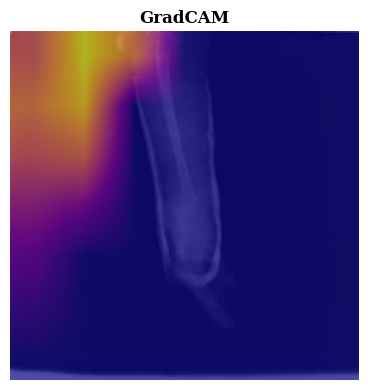

In [103]:
 # make a prediction and visualize grad-cam
def make_prediction_and_visualize_():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)


    last_conv_layer_name = 'conv5_block16_2_conv'

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)


make_prediction_and_visualize_()

# **No. 2 : Explainable AI (GradCAM++)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Grad-CAM++ heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Grad-CAM++ heatmap using the model we've built)


In [104]:
# Function to save and display ScoreCAM
def save_and_display_gradcam_plusplus(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM++', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/DenseNet121_gradcam_plusplus.pdf')  # Save as pdf format
    plt.show()



# **GradCAM++ function**
### **Gradient Computation:** Derive gradients between predicted class and conv layer's output, indicating feature map importance.
### **Positive and Negative Gradients:** Split gradients into positive (activating) and negative (inhibiting) parts, signifying influential and counteractive regions.
### **Weighting and Aggregation:** Calculate separate importance weights from positive and negative gradients, combining them to determine feature map significance.
### **Weighted Sum and Heatmap:** Blend positive and negative weights to generate a weighted sum, utilized for heatmap creation, pinpointing significant regions contributing to the predicted class.

In [105]:
# Function to generate GradCAM++ heatmap
def make_gradcam_plusplus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get gradients
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads[0], axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Calculate guided gradients
    guided_grads = tf.cast(last_conv_layer_output > 0, 'float32') * grads[0]

    # Calculate importance weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Generate heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()


# **Visualization of Grad-Cam++**

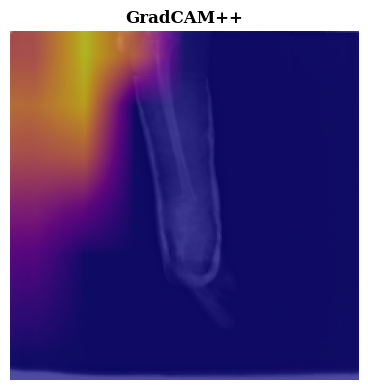

In [106]:
# Function to make a prediction and visualize GradCAM++
def make_prediction_and_visualize_gradcam_plusplus():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size
    rescaled_img = img / 255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_2_conv'

    # Generate GradCAM++ heatmap
    heatmap = make_gradcam_plusplus_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam_plusplus(img_path, heatmap)

make_prediction_and_visualize_gradcam_plusplus()

# **No. 3 : Explainable AI (ScoreCAM)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Score-CAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Score-CAM heatmap using the model we've built)


In [107]:
# Function to save and display ScoreCAM
def save_and_display_scorecam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the ScoreCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/DenseNet121_scorecam.pdf')  # Save as pdf format
    plt.show()



# **ScoreCAM function**
### **Gradient Computation:** Score-CAM calculates the gradients of the predicted class score with respect to the output feature maps, just like Grad-CAM. These gradients provide information about the importance of each feature map in the predicted class's activation.
### **Guided Gradients:** Instead of considering positive and negative gradients separately, Score-CAM utilizes guided gradients to focus only on positive gradients, i.e., gradients that have a positive influence on the predicted class. This step enhances the saliency of the significant regions.
### **Global Average Pooling (GAP):** Score-CAM performs Global Average Pooling (GAP) across the spatial dimensions of the guided gradients to generate importance weights for each feature map, indicating their relevance to the predicted class.
### **Score-weighted Activation Map:** The technique computes a score-weighted activation map by multiplying the weights obtained from GAP with the feature maps and summing across channels. This highlights the regions in the feature maps that contribute the most to the predicted class, emphasizing the most discriminative areas in the input image.

In [108]:
import tensorflow as tf

def make_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)
    guided_grads = tf.cast(grads[0] > 0, 'float32') * grads[0]

    # GAP (Global Average Pooling) along the spatial dimensions
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Calculate the score-weighted activation map
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of ScoreCam**

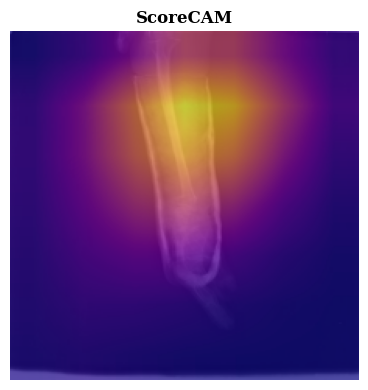

In [109]:
# make a prediction and visualize ScoreCAM
def make_prediction_and_visualize_scorecam():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_2_conv'

    # Generate class activation heatmap
    heatmap = make_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_scorecam(img_path, heatmap)

make_prediction_and_visualize_scorecam()


# **No. 4 : Explainable AI (Faster Score-CAM)**
### **step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Faster Score-CAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Faster Score-CAM heatmap using the model we've built)


# **Function for displaying Original and Faster ScoreCAM images**

In [110]:
# Function to save and display Faster ScoreCAM
def save_and_display_faster_scorecam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the Faster ScoreCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Faster ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/DenseNet121_faster_scorecam.pdf')  # Save as pdf format
    plt.show()



# **Faster ScoreCAM function**
### **Gradient Calculation:** Using a GradientTape, it computes the gradients of the predicted class output with respect to the output feature map of the specified last convolutional layer.

### **Global Average Pooling (GAP):** The gradients obtained are subjected to Global Average Pooling (GAP) along the spatial dimensions, resulting in weights representing the importance of each feature map in the predicted class's activation.

### **Weighted Sum Calculation:** Reshaping the obtained weights and the convolutional output, the function performs matrix multiplication between them, efficiently obtaining a score-weighted activation map that highlights significant regions related to the predicted class.

###  **Normalization and ReLU:** The resulting score-weighted activation map is normalized and subjected to ReLU (Rectified Linear Unit) activation, ensuring non-negativity and scaling to highlight the most influential regions.

In [111]:
def faster_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradient of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Reshape conv_output to match the dimensions for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map efficiently
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of faster ScoreCam**

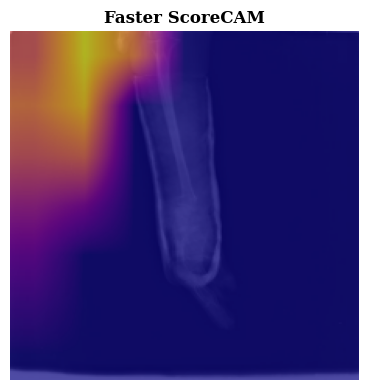

In [112]:
# make a prediction and visualize Faster ScoreCAM
def make_prediction_and_visualize_faster_scorecam():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_2_conv'

    # Generate class activation heatmap
    heatmap = faster_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_faster_scorecam(img_path, heatmap)

make_prediction_and_visualize_faster_scorecam()


# **No. 5 : Explainable AI (LayerCAM)**

### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the LayerCAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the LayerCAM heatmap using the model we've built)

# **Function for displaying Original and LayerCAM images**

In [113]:
# Function to save and display layercam
def save_and_display_layercam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('LayerCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/DenseNet121_layercam.pdf')  # Save as pdf format
    plt.show()



# **LayerCAM function**
###  **Gradient Calculation:** Utilize a gradient tape to compute gradients of the predicted class score with respect to the output feature maps obtained from the chosen layer.

###  **Global Average Pooling (GAP):** Perform Global Average Pooling across the spatial dimensions of the gradients to generate importance weights for each feature map.

### **Weight Reshaping:** Reshape the obtained weights to fit the required dimensions for subsequent matrix multiplication.

### **Activation Map Computation:** Compute a score-weighted activation map by performing a matrix multiplication between the reshaped weights and the output feature maps from the chosen layer.

### **Activation Map Adjustment:** Apply Rectified Linear Unit (ReLU) to ensure non-negativity in the heatmap.

### **Normalization:** Normalize the heatmap to ensure that the values fall within a certain range, often between 0 and 1, which aids in visualization.

In [114]:
import tensorflow as tf

def generate_layercam_heatmap(img_array, model, last_conv_layer_name, target_class_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if target_class_index is None:
            target_class_index = tf.argmax(preds[0])
        class_output = preds[:, target_class_index]
        conv_output = last_conv_layer_output[0]

    # Calculate gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Expand dimensions of conv_output for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map (LayerCAM)
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of LayerCAM**

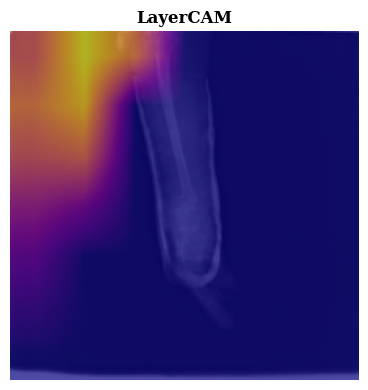

In [115]:
# make a prediction and visualize layercam
def make_prediction_and_visualize_layercam():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))#IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_2_conv'

    # Generate class activation heatmap
    heatmap = generate_layercam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_layercam(img_path, heatmap)


make_prediction_and_visualize_layercam()

# **No. 6 : Explainable AI (Vanilla Saliency)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Vanilla Saliency heatmap)
### **Step 3:** Get the Saliency Maps (We'll create a function to generate the Vanilla Saliency heatmap using the model we've built)


In [116]:
def save_and_display_saliency_map(img_path, saliency_map):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    blended = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)


    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.title('Vanilla Saliency', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/DenseNet121_vanilla_saliency.pdf')
    plt.show()


# **Saliency Map function**
### **Gradient Calculation:** Calculate the gradients of the predicted class's score concerning these feature maps. These gradients illustrate how changes in the feature maps affect the model's confidence in predicting a specific class. Higher gradients indicate more critical regions within the feature maps.

### **Importance Weighting through Global Average Pooling (GAP):** Apply Global Average Pooling across each feature map's spatial dimensions. This step calculates the importance weight assigned to each feature map in influencing the predicted class. The weights reflect the significance of each feature map's contribution.

### **Weighted Combination:** Create a weighted combination of the feature maps based on the importance weights obtained from the Global Average Pooling step. This combination emphasizes the regions within the feature maps that strongly impact the model's decision for the predicted class.

In [117]:
def generate_vanilla_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_index = tf.argmax(preds[0])

        # Get the predicted score for the highest probability class
        top_class_score = preds[:, top_pred_index]

    # Compute the gradients of the top class score with respect to the input image
    grads = tape.gradient(top_class_score, img_tensor)
    saliency_map = tf.abs(grads)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)

    return saliency_map[0].numpy()

# **Visualization of Saliency Map**

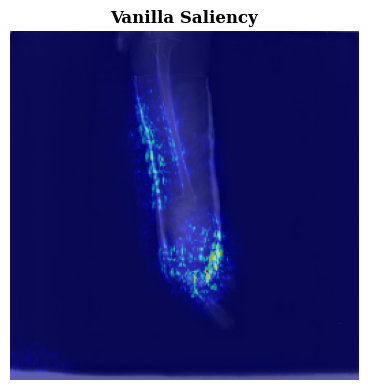

In [118]:
# make a prediction and visualize Vanilla Saliency
def make_prediction_and_visualize_vanilla_saliency():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'   

   # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize the image to match model input size

    # Preprocess the image (normalize pixel values)
    img = img / 255.0
    


    # Generate class activation heatmap
    saliency_map = generate_vanilla_saliency_map(img, loaded_model)

    
# Display the saliency map overlay
    save_and_display_saliency_map(img_path, saliency_map)

make_prediction_and_visualize_vanilla_saliency()

# **No. 7 : Explainable AI (SmoothGrad)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the SmoothGrad heatmap)
### **Step 3:** Get the Saliency Maps (We'll create a function to generate the SmoothGrad heatmap using the model we've built)

# **Function for displaying SmoothGrad images**

In [119]:
def save_and_display_SmoothGrad(img_path, saliency_map):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    blended = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)


    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.title('Smooth Grad', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/DenseNet121_smooth_grad.pdf')
    plt.show()



# **SmoothGrad function**
### **Model Prediction:** Use a pre-trained model to make predictions on the input image. Retrieve the index corresponding to the highest predicted class probability.

### **Gradient Accumulation:** Initialize a tensor for accumulating gradients (total_gradients). Repeat the process n times:

a. Generate a perturbed version of the input image by adding Gaussian noise (noise) to the original image tensor.

b. Compute the model's predictions on the perturbed image and obtain the class score for the top predicted class.

c. Calculate the gradients of the top class score with respect to the perturbed image.

d. Accumulate the gradients obtained from each perturbed image into total_gradients.

### **Average Gradients:** Divide total_gradients by the total number of perturbed images (n) to obtain averaged gradients (averaged_gradients). These averaged gradients represent the average sensitivity of the model's predictions to perturbations in each pixel of the input image.

### **Saliency Map Generation:** Calculate the absolute values of the averaged gradients, take the maximum across the color channels, and obtain the saliency map by reducing the tensor to a single channel (2D) image.



In [120]:
def generate_smoothgrad_saliency_map(img_array, model, n=50, sigma=1.0):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    img_tensor = tf.cast(img_tensor, dtype=tf.float32)  # Convert to float32

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_index = tf.argmax(preds[0])

        # Get the predicted score for the highest probability class
        top_class_score = preds[:, top_pred_index]

    total_gradients = tf.zeros_like(img_tensor)  # Initialize total gradients

    for _ in range(n):
        # Create perturbed versions of the input image with Gaussian noise
        noise = tf.random.normal(shape=img_tensor.shape, mean=0.0, stddev=sigma)
        perturbed_img = img_tensor + noise

        # Compute gradients for perturbed image
        with tf.GradientTape() as perturbed_tape:
            perturbed_tape.watch(perturbed_img)
            perturbed_preds = model(perturbed_img)
            perturbed_top_class_score = perturbed_preds[:, top_pred_index]

        # Compute gradients of the top class score w.r.t. perturbed image
        perturbed_grads = perturbed_tape.gradient(perturbed_top_class_score, perturbed_img)

        # Accumulate gradients
        total_gradients += perturbed_grads

    # Average gradients over perturbed images
    averaged_gradients = total_gradients / n

    saliency_map = tf.abs(averaged_gradients)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)

    return saliency_map[0].numpy()

# **Visualization of SmoothGrad**

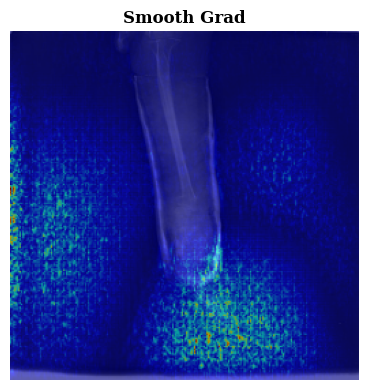

In [121]:
def make_prediction_and_visualize_smoothgrad_saliency():
    img_path = '/kaggle/input/fracture-classification/Fracture/test/Fractured/IMG0001381.png'


    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize the image to match model input size

    # Preprocess the image (normalize pixel values)
    img = img / 255.0



    # Generate SmoothGrad saliency map
    heatmap = generate_smoothgrad_saliency_map(img, loaded_model)

    # Display the saliency map overlay
    save_and_display_SmoothGrad(img_path, heatmap)


# Assuming loaded_model and other necessary components are defined
make_prediction_and_visualize_smoothgrad_saliency()

